# Speech Commands Recognition


*   Xi Deng (xd487)
*   Zulong Ye (zy2010)


## 0 Overview
Nowadays, with the popularization of smart devices, speech recognition has become a
promising way to reduce people’s screen addiction. Speech recognition provides an effective
approach for us to hands-free interact with all those screens, and the most important factor
of voice recognition is its accuracy. It is never easy to transcript audio speech because
human voices vary a lot from person to person in terms of accents, tones, paces and so on.
In this project, we plan to develop an algorithm based on CNN or RNN with LSTM(Long
Short-term Memory) that understands simple spoken commands. We will use the Speech
Commands Dataset from Google TensorFlow, which includes 65,000 utterances by thousands of different people. We need to predict the exact command labels in test data “yes”,
“no”, “up”, “down”, etc. after training.


## 1 Import library
We import libraries used for audio data processing, math, visuailization and so on.

In [ ]:
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from os.path import isdir, join
from pathlib import Path

from scipy import signal
from scipy.io import wavfile

%matplotlib inline

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras import backend as K
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPool1D, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint


## 2 Data

The datasets are downloaded from Kaggle competiion [https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data)  
  
The datasets sets are also uploaded into the Google Drive [https://drive.google.com/drive/folders/1rtyJr-AxVN6q_nP4ZtCPgjcfp8g9VPlY?usp=sharing](https://drive.google.com/drive/folders/1rtyJr-AxVN6q_nP4ZtCPgjcfp8g9VPlY?usp=sharing)
  
These data link from Google can be accessed by @nyu account directly. We use them by importing into Google Colab to make it easier reading.  
To access these data from the Google drive, we need to log in our @nyu google account Firstly. Secondly, we can store the data of above link to our own drive. Thirdly, we can record the path and use the path to read specific data.

### 2.1 Data path

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
audio_path= '/content/drive/MyDrive/Data/audio/'

### 2.2 Data visualization
We choose a data sample randomly, read the speech data and do the visualization.  
  
> Data visulization method refer to [https://www.kaggle.com/davids1992/speech-representation-and-data-exploration](https://www.kaggle.com/davids1992/speech-representation-and-data-exploration)



In [ ]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate / 1e3))
  freqs, times, spec = signal.spectrogram(audio,fs=sample_rate,window='hann',nperseg=nperseg,noverlap=noverlap,detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)

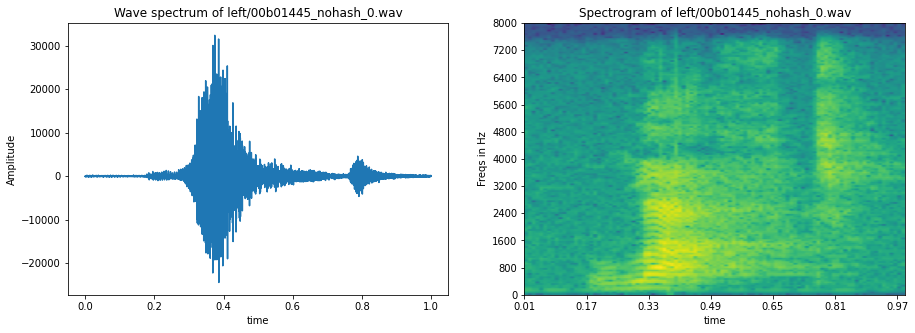

In [ ]:
# To test one sample: "left"

filename = 'left/00b01445_nohash_0.wav'
sample_rate, samples = wavfile.read(str(audio_path) + filename)

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121) # 1,2,1 the first image
ax1.set_title('Wave spectrum of ' + 'left/00b01445_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

freqs, times, spectrogram = log_specgram(samples, sample_rate)

ax2 = fig.add_subplot(122) # 1,2,2 the second image
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('time')
plt.show()

In [ ]:
ipd.Audio(samples, rate=sample_rate)
samples=np.array(samples, dtype='float64')
samples = signal.resample(samples, sample_rate)
ipd.Audio(samples, rate=sample_rate)

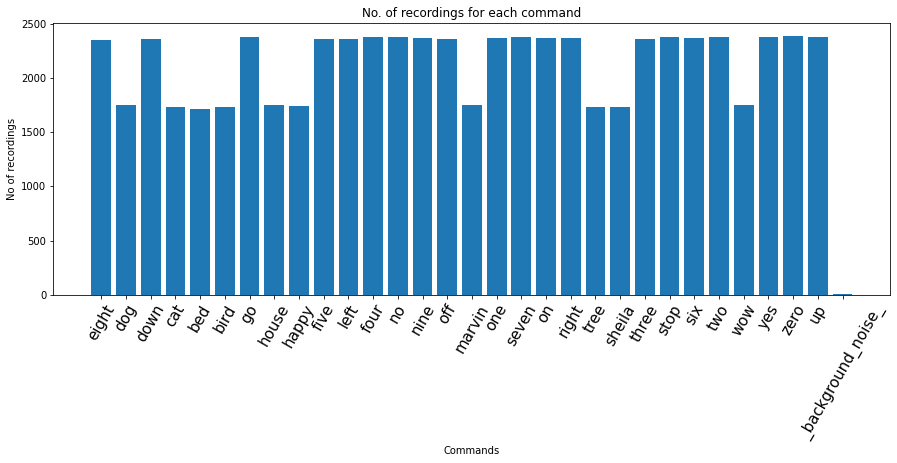

In [ ]:
labels=os.listdir(audio_path)

# Find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(15,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=10)
plt.ylabel('No of recordings', fontsize=10)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

### 2.3 Load data

In [ ]:
waves_all_datasets = [] # all samples information
labels_all_datasets = [] # all samples corresponding label

s_rate = 16000 # set the sample rate
labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#### 2.3.1 Load data from wave files

In [ ]:
# Wave files path

audio_path= '/content/drive/MyDrive/Data/audio/'

In [ ]:
# Read the wave information

b, a = signal.butter(1, 0.2, 'highpass') 

for label in labels:
  
  waves = [f for f in os.listdir(audio_path + '/'+ label) if f.endswith('.wav')]
  for wav in waves:
    sample_rate, samples = wavfile.read(audio_path + '/' + label + '/' + wav)   
    samples = signal.filtfilt(b, a, samples)  # filter

    if(len(samples)== s_rate): 
      waves_all_datasets.append(samples)
      labels_all_datasets.append(label)

In [ ]:
# Save wave data to txt

# write waves to txt file
np.savetxt("waves.txt", waves_all_datasets)

# write labels to txt file
fileObject = open('labels.txt','w')
for word in labels_all_datasets:
    fileObject.write(word)
    fileObject.write('\n')
fileObject.close()

#### 2.3.2 Load data from txt files

In order to accelerate the speed of reading audio files, we use another storing data to txt and read method to get data information for test.

In [ ]:
# Txt files path

wave_txt_path = '/content/drive/MyDrive/Data/'
label_txt_path = '/content/drive/MyDrive/Data/'

In [ ]:
# read wave data information
waves_all_datasets = np.loadtxt(wave_txt_path + 'waves.txt')

In [ ]:
# read corresponding labels
with open(label_txt_path + 'labels.txt', "r", encoding="utf-8", errors='ignore') as f:
  data = f.readlines()
  for line in data:
    word = line.strip() #list
    labels_all_datasets.append(word)

### 2.4 Data pre-processing

According to the competition, we choose "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go" these 10 commands as the target for recognition.  
  
For each speech sample, we create array to store signal data information and normalize them. For each kind of commands, we create labels corresponding to numbers.

In [ ]:
label_e = LabelEncoder()
y = label_e.fit_transform(labels_all_datasets)
classes = list(label_e.classes_)
y = np_utils.to_categorical(y, num_classes=len(labels))

In [ ]:
waves_all_datasets = waves_all_datasets / (2 ** (16 - 1))
waves_all_datasets = np.array(waves_all_datasets).reshape(-1, s_rate, 1)

In [ ]:
# split the test dataset
x_train, x_test, y_train, y_test = train_test_split(np.array(waves_all_datasets), np.array(y), stratify=y, test_size=0.20, random_state=777, shuffle=True)

# split train and validation dataset
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
print('training data shape:', x_tr.shape)
print('validation data shape:', x_val.shape)
print('test data shape:', x_test.shape)

training data shape: (12786, 16000, 1)
validation data shape: (4263, 16000, 1)
test data shape: (4263, 16000, 1)


## 3 Training Model



### 3.1 CNN


In [ ]:
K.clear_session()

inputs = Input(shape = (s_rate,1))
d_out = 0.2
x_in = BatchNormalization(name='batch_in')(inputs)

for i in range(9):
  name = 'level_' + str(i)
  x_in = Conv1D(8*(2**i), (9), padding='same', activation='relu', name='conv_'+name)(x_in)
  x_in = BatchNormalization(name='batch_'+name)(x_in)
  x_in = MaxPooling1D((2), padding='same', name='max_pool_'+name)(x_in)

x_in = Conv1D(1024, (1), name='Last_level')(x_in)
x_in = GlobalMaxPool1D()(x_in) # only g max
x_in = Dense(1024, activation='relu', name='Dense_level')(x_in)
x_in = Dropout(d_out)(x_in)
outputs = Dense(len(labels), activation='softmax', name='cls')(x_in)

model_cnn = Model(inputs, outputs)
model_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000, 1)]        0         
_________________________________________________________________
batch_in (BatchNormalization (None, 16000, 1)          4         
_________________________________________________________________
conv_level_0 (Conv1D)        (None, 16000, 8)          80        
_________________________________________________________________
batch_level_0 (BatchNormaliz (None, 16000, 8)          32        
_________________________________________________________________
max_pool_level_0 (MaxPooling (None, 8000, 8)           0         
_________________________________________________________________
conv_level_1 (Conv1D)        (None, 8000, 16)          1168      
_________________________________________________________________
batch_level_1 (BatchNormaliz (None, 8000, 16)          64    

In [ ]:
model_cnn.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, min_delta=0.00001)
history=model_cnn.fit(x_tr, y_tr ,epochs=300, callbacks=[es], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/300
400/400 [==============================] - 31s 70ms/step - loss: 2.2211 - accuracy: 0.5194 - val_loss: 1.0747 - val_accuracy: 0.6181
Epoch 2/300
400/400 [==============================] - 28s 69ms/step - loss: 0.3936 - accuracy: 0.8685 - val_loss: 0.6928 - val_accuracy: 0.7577
Epoch 3/300
400/400 [==============================] - 28s 69ms/step - loss: 0.2576 - accuracy: 0.9138 - val_loss: 0.3035 - val_accuracy: 0.8968
Epoch 4/300
400/400 [==============================] - 28s 69ms/step - loss: 0.1835 - accuracy: 0.9394 - val_loss: 0.7676 - val_accuracy: 0.7464
Epoch 5/300
400/400 [==============================] - 28s 69ms/step - loss: 0.1490 - accuracy: 0.9511 - val_loss: 0.6937 - val_accuracy: 0.7725
Epoch 6/300
400/400 [==============================] - 28s 69ms/step - loss: 0.1178 - accuracy: 0.9613 - val_loss: 0.3282 - val_accuracy: 0.8881
Epoch 7/300
400/400 [==============================] - 28s 69ms/step - loss: 0.0867 - accuracy: 0.9702 - val_loss: 0.2114 - val_ac

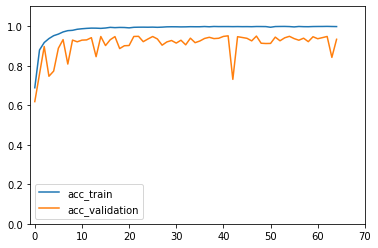

In [ ]:
plt.plot(history.history['accuracy'], label='acc_train') 
plt.plot(history.history['val_accuracy'], label='acc_validation') 
plt.ylim([0, 1.1])
plt.xlim([-1,70])
plt.legend()
plt.show()

In [ ]:
model_cnn.evaluate(x=x_test, y=y_test)

134/134 [==============================] - 2s 16ms/step - loss: 0.2937 - accuracy: 0.9353


[0.2936517894268036, 0.935256838798523]

### 3.2 CNN + LSTM

In [ ]:
K.clear_session()

inputs = Input(shape=(s_rate,1))

# Conv1D layer
x_in = Conv1D(filters=256, kernel_size=32, padding='same', activation='relu', strides=8)(inputs)
x_in = MaxPooling1D(pool_size=16, strides=None)(x_in)
x_in = Dropout(d_out)(x_in)

# lstm layer ref https://keras.io/api/layers/recurrent_layers/lstm/

x_in = LSTM(256, return_sequences=True, dropout=d_out, name='lstm_1')(x_in)
x_in = LSTM(256, return_sequences=True, dropout=d_out, name='lstm_2')(x_in)


# Flatten layer
x_in = Flatten()(x_in)

# Dense Layer
x_in = Dense(64, activation='relu')(x_in)
x_in = Dropout(d_out)(x_in)

outputs = Dense(len(labels), activation='softmax')(x_in)

model_lstm = Model(inputs, outputs)
model_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 256)         8448      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 125, 256)          525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 125, 256)          525312    
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0     

In [ ]:
adam = Adam(lr=1e-4, clipnorm=1.0)
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
history_lstm=model_lstm.fit(x_tr, y_tr, epochs=100, callbacks=[es], batch_size=128, validation_data=(x_val,y_val)) 

Epoch 1/100
100/100 [==============================] - 10s 60ms/step - loss: 2.2500 - accuracy: 0.1442 - val_loss: 1.7334 - val_accuracy: 0.3594
Epoch 2/100
100/100 [==============================] - 5s 51ms/step - loss: 1.7187 - accuracy: 0.3727 - val_loss: 1.4130 - val_accuracy: 0.4722
Epoch 3/100
100/100 [==============================] - 5s 51ms/step - loss: 1.4048 - accuracy: 0.4689 - val_loss: 1.2542 - val_accuracy: 0.5337
Epoch 4/100
100/100 [==============================] - 5s 51ms/step - loss: 1.2264 - accuracy: 0.5396 - val_loss: 0.9512 - val_accuracy: 0.6542
Epoch 5/100
100/100 [==============================] - 5s 51ms/step - loss: 1.0103 - accuracy: 0.6280 - val_loss: 0.8449 - val_accuracy: 0.6829
Epoch 6/100
100/100 [==============================] - 5s 51ms/step - loss: 0.8356 - accuracy: 0.6914 - val_loss: 0.7066 - val_accuracy: 0.7403
Epoch 7/100
100/100 [==============================] - 5s 51ms/step - loss: 0.7392 - accuracy: 0.7287 - val_loss: 0.6170 - val_accuracy

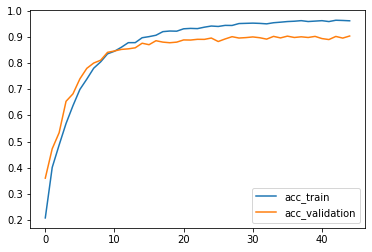

In [ ]:
plt.plot(history_lstm.history['accuracy'], label='acc_train') 
plt.plot(history_lstm.history['val_accuracy'], label='acc_validation') 
plt.legend()
plt.show()

In [ ]:
model_lstm.evaluate(x_test, y_test)

134/134 [==============================] - 2s 12ms/step - loss: 0.4494 - accuracy: 0.9113


[0.4494383633136749, 0.9113300442695618]

## 4 Predict
With the traning model, we use the confusion matrix to get each accuracy. We also choose the data randomly to test the prediction result.

### 4.1 Confusion matrix

In [ ]:
def predict_matrix(x_in, y_in, model):
  y_ts_hat = model.predict(x_in)
  y_ts_index = np.argmax(y_in, axis=1)
  y_ts_hat_index = np.argmax(y_ts_hat, axis=1)
  cf_matrix = confusion_matrix(y_ts_index, y_ts_hat_index)
  
  # Normalize the confusion matrix
  cf_matrix_sum = np.sum(cf_matrix,1)
  cf_matrix = cf_matrix / cf_matrix_sum[None, :]
  
  return cf_matrix

In [ ]:
def plot_matrix(cf_matrix, l_name):
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in list(l_name)],
              columns = [i for i in list(l_name)])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, center=0.5, fmt='.3f', cmap="RdPu", linewidths=1)
  plt.show()

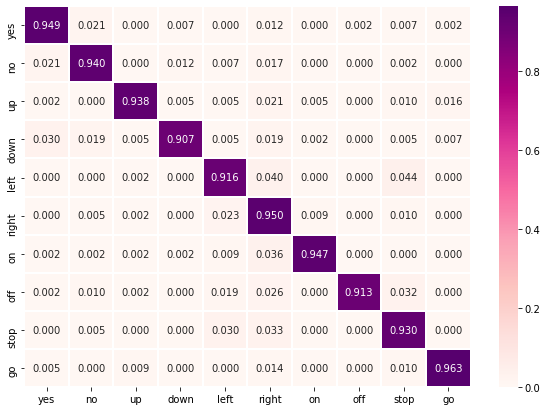

In [ ]:
# CNN model predict result confustion matrix

cf_matrix_cnn = predict_matrix(x_test, y_test, model_cnn)
plot_matrix(cf_matrix_cnn, labels)

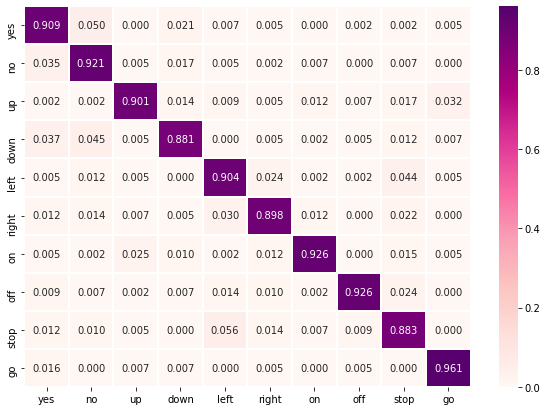

In [ ]:
# LSTM model predict result confustion matrix

cf_matrix_lstm = predict_matrix(x_test, y_test, model_lstm)
plot_matrix(cf_matrix_lstm, labels)

### 4.2 Label predict test random

In [ ]:
def predict_cnn(audio):
  prob = model_cnn.predict(audio.reshape(1,s_rate,1))
  index = np.argmax(prob[0])
  return classes[index]

In [ ]:
def predict_lstm(audio):
  prob = model_lstm.predict(audio.reshape(1,s_rate,1))
  index = np.argmax(prob[0])
  return classes[index]

In [ ]:
import random
for i in range(100):
  index = random.randint(0,len(x_val)-1)
  samples = x_val[index].ravel()
  print("Audio:",classes[np.argmax(y_val[index])])
  # ipd.Audio(samples, rate=s_rate)
  print("Text (CNN):",predict_cnn(samples))
  print("Text (LSTM):",predict_lstm(samples))

Audio: go
Text (CNN): go
Text (LSTM): go
Audio: on
Text (CNN): on
Text (LSTM): on
Audio: on
Text (CNN): on
Text (LSTM): on
Audio: up
Text (CNN): up
Text (LSTM): up
Audio: down
Text (CNN): down
Text (LSTM): down
Audio: left
Text (CNN): left
Text (LSTM): left
Audio: yes
Text (CNN): yes
Text (LSTM): yes
Audio: go
Text (CNN): go
Text (LSTM): go
Audio: go
Text (CNN): go
Text (LSTM): go
Audio: no
Text (CNN): no
Text (LSTM): no
Audio: go
Text (CNN): stop
Text (LSTM): off
Audio: yes
Text (CNN): yes
Text (LSTM): yes
Audio: right
Text (CNN): right
Text (LSTM): right
Audio: down
Text (CNN): down
Text (LSTM): down
Audio: right
Text (CNN): right
Text (LSTM): down
Audio: on
Text (CNN): on
Text (LSTM): on
Audio: no
Text (CNN): no
Text (LSTM): no
Audio: left
Text (CNN): left
Text (LSTM): left
Audio: up
Text (CNN): up
Text (LSTM): up
Audio: down
Text (CNN): down
Text (LSTM): down
Audio: yes
Text (CNN): yes
Text (LSTM): yes
Audio: go
Text (CNN): go
Text (LSTM): go
Audio: on
Text (CNN): on
Text (LSTM): o

## 5 Analysis  
In this project, we manage to implement a deep convolutional neural network and a combination of CNN with LSTM network, as well as apply both networks on the Speech Commands Dataset from Google TensorFlow. Now we have accomplished the feature extractions of audio files, and increased the speed of audio data processing greatly. Most importantly, we have acquired very high recognition precisions on both finalized networks, which shows a significant improvement on what we did in the project update. As a result, the complex CNN model has slightly better performance compared to the CNN with LSTM model, while the CNN with LSTM model runs much faster than the complex CNN model. Furthermore, we found that CNN performance is sensitive to padding mode and pooling size, rather than filter size. In addition, CNN performance can be enhanced by adding more and more layers to make the network very deep but LSTM cannot.  
  
We plan to apply our system on some large-vocabulary speech dataset, or try some other feature extraction approaches like Mel Frequency Cepstrum Coefficient(MFCC) in the future. We may also try some new models such as Transformers/BERT, and we can compare the performance of these different models.
